# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


#  Import necessary libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, roc_auc_score, \
    classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop



%pip install ucimlrepo

# Load the dataset

from ucimlrepo import fetch_ucirepo


# Load the dataset and prepare the target variable

In [2]:
# Load the dataset
df = fetch_ucirepo(id=193)

# Extract data as pandas DataFrames
X = df.data.features
y = df.data.targets

# Drop the first column of the target variable
y = y.iloc[:, 1]  # Selecting the NSP column (Normal, suspect, pathologic)

# Zielvariable (y) bleibt numerisch, keine Kodierung nötig für Logistische Regression und SVM


## Model Selection

[Discuss the type(s) of models you consider for this task, and justify the selection.]



# Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


## Create two datasets: One with all features and one with selected features (selectKBesT)

## Dataset with all features:

In [8]:
# Create dataset with all features (no filtering)
X_all = X  # Use all features

## Dataset with selected features (SelectKBest)

In [9]:
# Feature selection with SelectKBest
bestfeatures = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
fit = bestfeatures.fit(X, y)  # Fit on the data

# Combine scores and feature names for reference
dfscores = pd.DataFrame(fit.scores_, columns=['Score'])
dfcolumns = pd.DataFrame(X.columns, columns=['Specs'])
featureScores = pd.concat([dfcolumns, dfscores], axis=1)

# Select the top 10 features
top_features = featureScores.nlargest(10, 'Score')['Specs']
X_selected = X[top_features]

# Drop 'Mode' and 'Median' columns due to high correlation with 'Mean'
X_selected = X_selected.drop(['Mode', 'Median'], axis=1)

## Split datasets into training and testing sets

## Dataset with all features

In [10]:
# Splitting the dataset with all features
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# Standardize the features
scaler_all = StandardScaler()
X_train_scaled_all = scaler_all.fit_transform(X_train_all)
X_test_scaled_all = scaler_all.transform(X_test_all)

## Dataset with selected features

In [11]:
# Splitting the dataset with selected features
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Standardize the features
scaler_selected = StandardScaler()
X_train_scaled_selected = scaler_selected.fit_transform(X_train_selected)
X_test_scaled_selected = scaler_selected.transform(X_test_selected)

## Prepare the target variable for the neural network

In [12]:
from tensorflow.keras.utils import to_categorical


# Convert target variable to one-hot encoding (only for neural network)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [ ]:
# Implement hyperparameter tuning
# Example using GridSearchCV with a DecisionTreeClassifier
# param_grid = {'max_depth': [2, 4, 6, 8]}
# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)


# Implementation

[Implement the final model(s) you've selected based on the above steps.]


##  Build the Neural Network

In [24]:
def build_and_train_nn(X_train_scaled, y_train_categorical, X_test_scaled, y_test_categorical, input_dim):
    """
    Builds, trains, and evaluates a neural network model.

    Parameters:
    X_train_scaled: Pre-scaled training features
    y_train_categorical: One-hot encoded training labels
    X_test_scaled: Pre-scaled test features
    y_test_categorical: One-hot encoded test labels
    input_dim: Number of input features (dimensionality of input)

    Returns:
    model: Trained neural network model
    history: Training history object
    y_pred: Predicted labels on the test set
    """

    # Build the neural network model
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(y_train_categorical.shape[1], activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_scaled, y_train_categorical,
                        validation_split=0.1,
                        epochs=200,
                        batch_size=64,
                        verbose=1)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)

    return model, history, y_pred_classes


## Train Neural Networks for Both Datasets


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Train the model on all features (without class weights)
nn_all_features, history_all, y_pred_all = build_and_train_nn(
    X_train_scaled_all, y_train_categorical, X_test_scaled_all, y_test_categorical,
    input_dim=X_train_scaled_all.shape[1]
)

# Train the model on selected features (without class weights)
nn_selected_features, history_selected, y_pred_selected = build_and_train_nn(
    X_train_scaled_selected, y_train_categorical, X_test_scaled_selected, y_test_categorical,
    input_dim=X_train_scaled_selected.shape[1]
)


# Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


## Evaluate and Compare the Neural Network Models (All Features versus Selected Features)

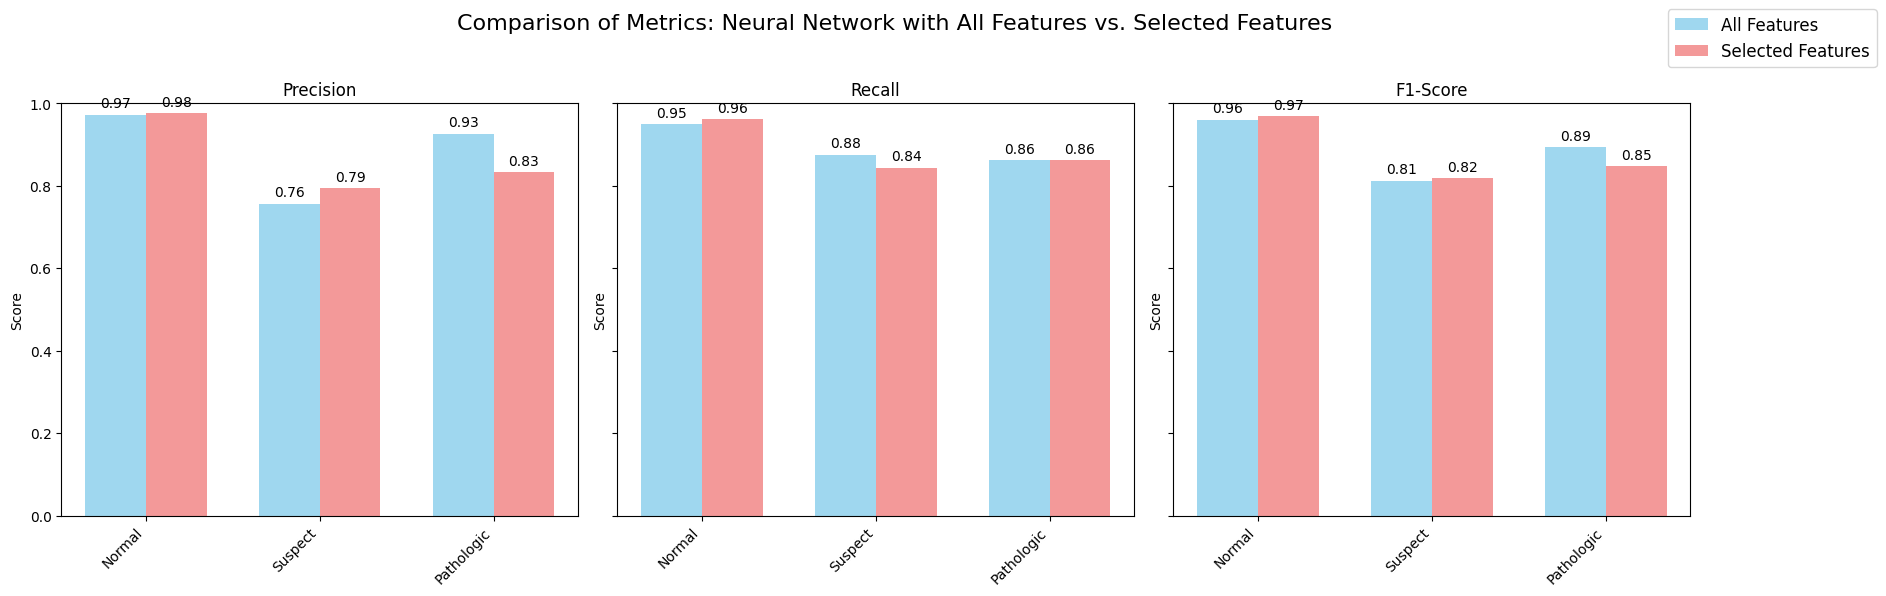


Model Comparison Summary:

Neural Network with All Features - Weighted Average Metrics:
Precision: 0.937
Recall: 0.932
F1-Score: 0.934

Neural Network with Selected Features - Weighted Average Metrics:
Precision: 0.939
Recall: 0.937
F1-Score: 0.937


In [26]:
def compare_nn_models(y_test, y_pred_all, y_pred_selected):
    """
    Compares the results of neural network models trained on all features and selected features.
    Returns the comparison metrics and creates visualization plots.

    Parameters:
    y_test: True test labels
    y_pred_all: Predicted labels from the model trained on all features
    y_pred_selected: Predicted labels from the model trained on selected features
    """
    # Get classification reports for both models
    report_all = classification_report(y_test, y_pred_all,
                                       target_names=["Normal", "Suspect", "Pathologic"],
                                       output_dict=True)
    report_selected = classification_report(y_test, y_pred_selected,
                                            target_names=["Normal", "Suspect", "Pathologic"],
                                            output_dict=True)

    # Create comparison DataFrame
    comparison_data = {
        'precision_All': [report_all[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_All': [report_all[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_All': [report_all[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]],
        'precision_Selected': [report_selected[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_Selected': [report_selected[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_Selected': [report_selected[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]]
    }

    comparison_df = pd.DataFrame(comparison_data,
                                 index=["Normal", "Suspect", "Pathologic"])

    # Create visualization
    metrics = ["Precision", "Recall", "F1-Score"]
    classes = comparison_df.index
    x = np.arange(len(classes))
    width = 0.35

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, metric in enumerate(metrics):
        if metric == "F1-Score":
            all_values = comparison_df['f1-score_All']
            selected_values = comparison_df['f1-score_Selected']
        else:
            all_values = comparison_df[f'{metric.lower()}_All']
            selected_values = comparison_df[f'{metric.lower()}_Selected']

        ax = axes[i]
        rects1 = ax.bar(x - width/2, all_values, width, label='All Features',
                        color='skyblue', alpha=0.8)
        rects2 = ax.bar(x + width/2, selected_values, width, label='Selected Features',
                        color='lightcoral', alpha=0.8)

        ax.set_title(metric)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)

        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width()/2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

    # Add a single legend to the entire figure
    fig.legend(['All Features', 'Selected Features'], loc='upper right', bbox_to_anchor=(1.05, 1), fontsize=12)
    fig.suptitle("Comparison of Metrics: Neural Network with All Features vs. Selected Features", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to accommodate the legend
    plt.show()

    # Print summary statistics
    print("\nModel Comparison Summary:")
    print("\nNeural Network with All Features - Weighted Average Metrics:")
    print(f"Precision: {report_all['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_all['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_all['weighted avg']['f1-score']:.3f}")

    print("\nNeural Network with Selected Features - Weighted Average Metrics:")
    print(f"Precision: {report_selected['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_selected['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_selected['weighted avg']['f1-score']:.3f}")

    return comparison_df

    # Compare the two neural network models
comparison_df_nn = compare_nn_models(
    y_test, y_pred_all, y_pred_selected
)



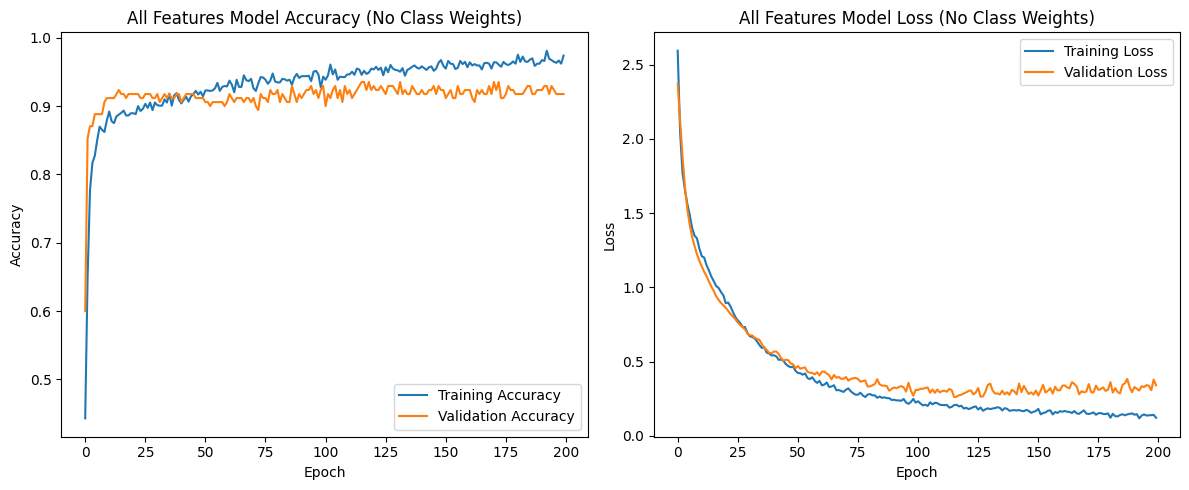

In [27]:
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_all.history['accuracy'], label='Training Accuracy')
plt.plot(history_all.history['val_accuracy'], label='Validation Accuracy')
plt.title('All Features Model Accuracy (No Class Weights)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_all.history['loss'], label='Training Loss')
plt.plot(history_all.history['val_loss'], label='Validation Loss')
plt.title('All Features Model Loss (No Class Weights)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Neural Network (All Features) ---
Accuracy: 0.93

Classification Report:
              precision    recall  f1-score     support
Normal         0.972308  0.948949  0.960486  333.000000
Suspect        0.756757  0.875000  0.811594   64.000000
Pathologic     0.925926  0.862069  0.892857   29.000000
accuracy       0.931925  0.931925  0.931925    0.931925
macro avg      0.884997  0.895339  0.888313  426.000000
weighted avg   0.936767  0.931925  0.933514  426.000000


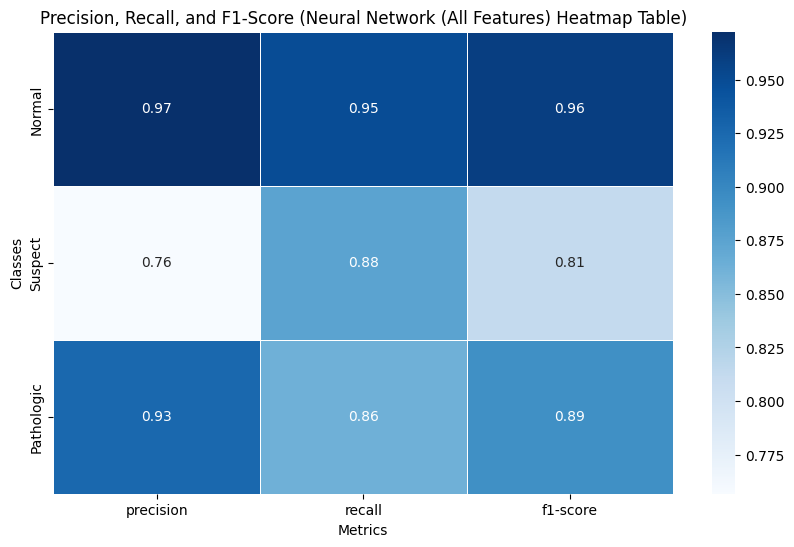

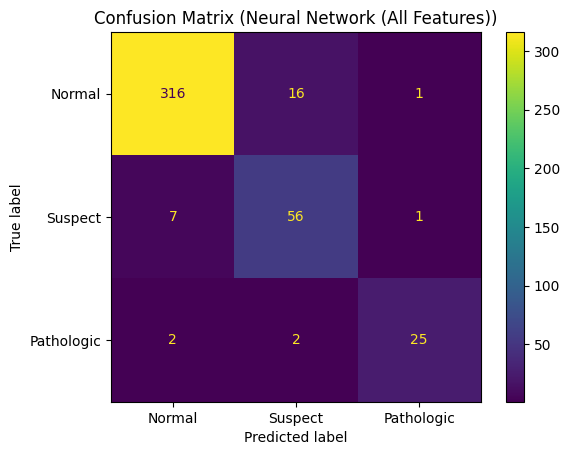

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_visualize_model_nn(model, X_test, y_test_categorical, model_name="Neural Network"):
    """
    Evaluates and visualizes the performance of a neural network model.

    Parameters:
    model: Trained neural network model
    X_test: Scaled test features
    y_test_categorical: One-hot encoded true labels for the test set
    model_name: Name of the model (e.g., "Neural Network")
    """
    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Klassenindex der höchsten Wahrscheinlichkeit
    y_test_classes = np.argmax(y_test_categorical, axis=1)  # One-Hot-Encoding zurückwandeln

    # Calculate accuracy
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    print("\nClassification Report:")
    report = classification_report(y_test_classes, y_pred_classes,
                                    target_names=["Normal", "Suspect", "Pathologic"],
                                    output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)

    # Visualize the classification report as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report.iloc[:-3, :3], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
    plt.title(f"Precision, Recall, and F1-Score ({model_name} Heatmap Table)")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.show()

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=["Normal", "Suspect", "Pathologic"])
    disp.plot(cmap="viridis")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()


# Evaluate the trained neural network model with all features
evaluate_and_visualize_model_nn(
    nn_all_features,
    X_test_scaled_all,
    y_test_categorical,
    model_name="Neural Network (All Features)"
)


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [ ]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")


# Undersampling of the Majority Class

In [17]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

def remove_similar_points(X, y, threshold=0.1):
    """
    Removes similar points from the majority class based on pairwise distances.

    Parameters:
    X: np.ndarray
        Feature matrix (scaled data).
    y: np.ndarray
        Target labels.
    threshold: float
        Distance threshold to consider points as "similar".

    Returns:
    X_reduced: np.ndarray
        Reduced feature matrix with similar points removed from the majority class.
    y_reduced: np.ndarray
        Reduced target labels.
    """
    # Identify the majority class
    majority_class = np.argmax(np.bincount(y))
    print(f"Majority class: {majority_class}")

    # Extract features and labels for the majority class
    X_majority = X[y == majority_class]
    y_majority = y[y == majority_class]

    # Compute pairwise distances for the majority class
    distances = pdist(X_majority, metric='euclidean')
    distance_matrix = squareform(distances)

    # Find points with distances below the threshold
    similar_points = np.where(distance_matrix < threshold)

    # Use a set to track points to remove
    to_remove = set()
    for i, j in zip(similar_points[0], similar_points[1]):
        if i != j:  # Ignore self-comparisons
            to_remove.add(j)

    # Remove redundant points
    X_majority_reduced = np.delete(X_majority, list(to_remove), axis=0)
    y_majority_reduced = np.delete(y_majority, list(to_remove), axis=0)

    print(f"Removed {len(to_remove)} similar points from the majority class.")

    # Combine with the other classes
    X_minority = X[y != majority_class]
    y_minority = y[y != majority_class]
    X_reduced = np.vstack((X_majority_reduced, X_minority))
    y_reduced = np.hstack((y_majority_reduced, y_minority))

    return X_reduced, y_reduced

# Set the threshold for similarity
distance_threshold = 0.1  # Adjust based on the scale of your data

# Remove similar points from the majority class
X_train_reduced, y_train_reduced = remove_similar_points(X_train_scaled_all, y_train, threshold=distance_threshold)

# Überprüfen der neuen Verteilung
print("Original class distribution:", np.bincount(y_train))
print("New class distribution after removing similar points:", np.bincount(y_train_reduced))


Majority class: 1
Removed 16 similar points from the majority class.
Original class distribution: [   0 1322  231  147]
New class distribution after removing similar points: [   0 1306  231  147]


## Train the neural network with the reduced dataset

In [ ]:
# One-hot encode the reduced labels
y_train_categorical_reduced = to_categorical(y_train_reduced)

# Train the neural network with the reduced dataset
nn_model_reduced, history_reduced, y_pred_reduced = build_and_train_nn(
    X_train_reduced, y_train_categorical_reduced, X_test_scaled_all, y_test_categorical,
    input_dim=X_train_reduced.shape[1],
)


## Compare the model with the reduced dataset with the model with all features and all data


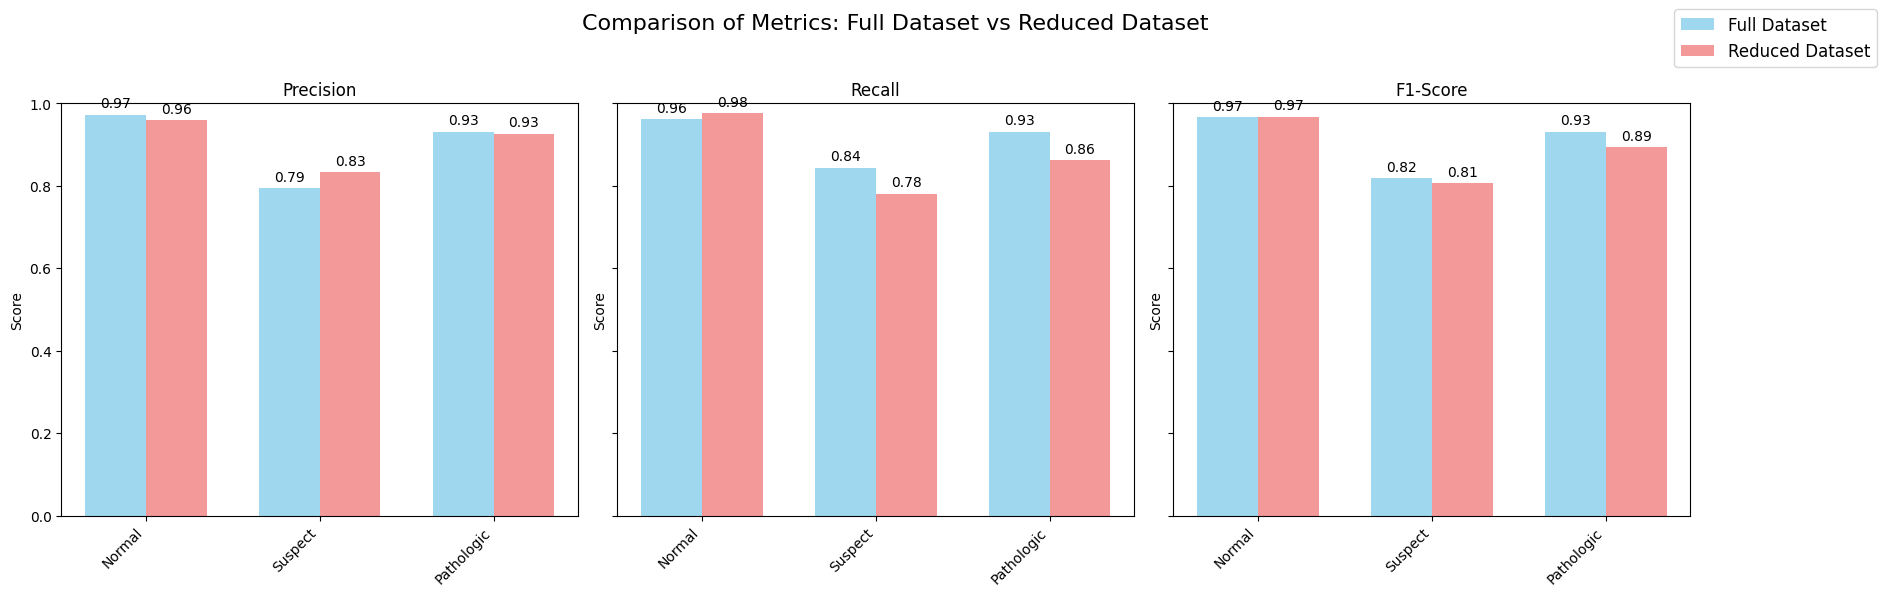


Model Comparison Summary:

Neural Network with Full Dataset - Weighted Average Metrics:
Precision: 0.943
Recall: 0.941
F1-Score: 0.942

Neural Network with Reduced Dataset - Weighted Average Metrics:
Precision: 0.938
Recall: 0.939
F1-Score: 0.938


In [19]:
def compare_nn_models(y_test, y_pred_full, y_pred_reduced):
    """
    Compares the results of neural network models trained on the full dataset and the reduced dataset.
    Returns the comparison metrics and creates visualization plots.

    Parameters:
    y_test: True test labels
    y_pred_full: Predicted labels from the model trained on the full dataset
    y_pred_reduced: Predicted labels from the model trained on the reduced dataset
    """
    # Get classification reports for both models
    report_full = classification_report(y_test, y_pred_full,
                                        target_names=["Normal", "Suspect", "Pathologic"],
                                        output_dict=True)
    report_reduced = classification_report(y_test, y_pred_reduced,
                                           target_names=["Normal", "Suspect", "Pathologic"],
                                           output_dict=True)

    # Create comparison DataFrame
    comparison_data = {
        'precision_Full': [report_full[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_Full': [report_full[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_Full': [report_full[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]],
        'precision_Reduced': [report_reduced[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_Reduced': [report_reduced[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_Reduced': [report_reduced[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]]
    }

    comparison_df = pd.DataFrame(comparison_data,
                                 index=["Normal", "Suspect", "Pathologic"])

    # Create visualization
    metrics = ["Precision", "Recall", "F1-Score"]
    classes = comparison_df.index
    x = np.arange(len(classes))
    width = 0.35

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, metric in enumerate(metrics):
        if metric == "F1-Score":
            full_values = comparison_df['f1-score_Full']
            reduced_values = comparison_df['f1-score_Reduced']
        else:
            full_values = comparison_df[f'{metric.lower()}_Full']
            reduced_values = comparison_df[f'{metric.lower()}_Reduced']

        ax = axes[i]
        rects1 = ax.bar(x - width/2, full_values, width, label='Full Dataset',
                        color='skyblue', alpha=0.8)
        rects2 = ax.bar(x + width/2, reduced_values, width, label='Reduced Dataset',
                        color='lightcoral', alpha=0.8)

        ax.set_title(metric)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)

        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width()/2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

    # Add a single legend to the entire figure
    fig.legend(['Full Dataset', 'Reduced Dataset'], loc='upper right', bbox_to_anchor=(1.05, 1), fontsize=12)
    fig.suptitle("Comparison of Metrics: Full Dataset vs Reduced Dataset", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to accommodate the legend
    plt.show()

    # Print summary statistics
    print("\nModel Comparison Summary:")
    print("\nNeural Network with Full Dataset - Weighted Average Metrics:")
    print(f"Precision: {report_full['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_full['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_full['weighted avg']['f1-score']:.3f}")

    print("\nNeural Network with Reduced Dataset - Weighted Average Metrics:")
    print(f"Precision: {report_reduced['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_reduced['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_reduced['weighted avg']['f1-score']:.3f}")

    return comparison_df

# Vergleiche NN Full Dataset vs. NN Reduced Dataset
comparison_df = compare_nn_models(
    y_test,
    y_pred_all,         # Vorhersagen für das Modell mit allen Daten
    y_pred_reduced      # Vorhersagen für das Modell mit reduzierten Daten
)


# Oversampling with SMOTE

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Erstelle eine SMOTE-Instanz
smote = SMOTE(random_state=42)

# Wende SMOTE auf die Trainingsdaten an
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_all, y_train)

# Überprüfe die neue Klassenverteilung
print("Original class distribution:", Counter(y_train))
print("New class distribution after SMOTE:", Counter(y_train_smote))

## Train the Model with SMOTE Data

In [ ]:
# One-hot encode die Labels nach SMOTE
y_train_categorical_smote = to_categorical(y_train_smote)

# Trainiere das neuronale Netzwerk mit den SMOTE-Daten
nn_model_smote, history_smote, y_pred_smote = build_and_train_nn(
    X_train_smote, y_train_categorical_smote, X_test_scaled_all, y_test_categorical,
    input_dim=X_train_smote.shape[1],
)

## Comparing the model trained with SMOTE data with the model trained with the real data and all features

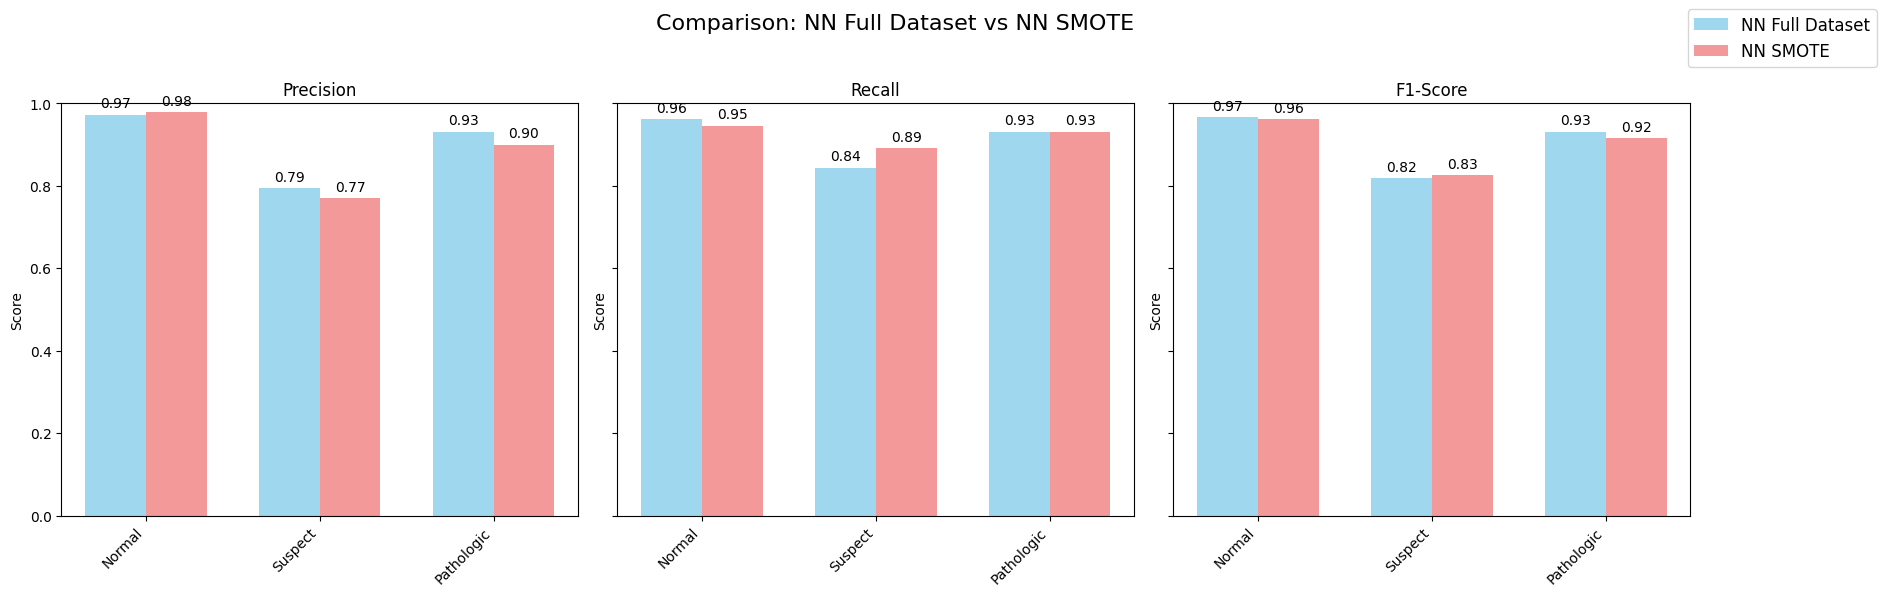


Model Comparison Summary (NN Full Dataset vs NN SMOTE):

NN Full Dataset - Weighted Average Metrics:
Precision: 0.943
Recall: 0.941
F1-Score: 0.942

NN SMOTE - Weighted Average Metrics:
Precision: 0.942
Recall: 0.937
F1-Score: 0.938


In [23]:
def compare_nn_models(y_test, y_pred_model1, y_pred_model2, model1_name="Model 1", model2_name="Model 2", title="Comparison of Models"):
    """
    Compares the results of two neural network models.
    Returns the comparison metrics and creates visualization plots.

    Parameters:
    y_test: True test labels
    y_pred_model1: Predicted labels from the first model
    y_pred_model2: Predicted labels from the second model
    model1_name: Name of the first model (for legend and labels)
    model2_name: Name of the second model (for legend and labels)
    title: Title of the plot
    """
    # Get classification reports for both models
    report_model1 = classification_report(y_test, y_pred_model1,
                                          target_names=["Normal", "Suspect", "Pathologic"],
                                          output_dict=True)
    report_model2 = classification_report(y_test, y_pred_model2,
                                          target_names=["Normal", "Suspect", "Pathologic"],
                                          output_dict=True)

    # Create comparison DataFrame
    comparison_data = {
        f'precision_{model1_name}': [report_model1[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        f'recall_{model1_name}': [report_model1[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        f'f1-score_{model1_name}': [report_model1[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]],
        f'precision_{model2_name}': [report_model2[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        f'recall_{model2_name}': [report_model2[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        f'f1-score_{model2_name}': [report_model2[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]]
    }

    comparison_df = pd.DataFrame(comparison_data,
                                 index=["Normal", "Suspect", "Pathologic"])

    # Create visualization
    metrics = ["Precision", "Recall", "F1-Score"]
    classes = comparison_df.index
    x = np.arange(len(classes))
    width = 0.35

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, metric in enumerate(metrics):
        if metric == "F1-Score":
            model1_values = comparison_df[f'f1-score_{model1_name}']
            model2_values = comparison_df[f'f1-score_{model2_name}']
        else:
            model1_values = comparison_df[f'{metric.lower()}_{model1_name}']
            model2_values = comparison_df[f'{metric.lower()}_{model2_name}']

        ax = axes[i]
        rects1 = ax.bar(x - width/2, model1_values, width, label=model1_name,
                        color='skyblue', alpha=0.8)
        rects2 = ax.bar(x + width/2, model2_values, width, label=model2_name,
                        color='lightcoral', alpha=0.8)

        ax.set_title(metric)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)

        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width()/2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

    # Add a single legend to the entire figure
    fig.legend([model1_name, model2_name], loc='upper right', bbox_to_anchor=(1.05, 1), fontsize=12)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to accommodate the legend
    plt.show()

    # Print summary statistics
    print(f"\nModel Comparison Summary ({model1_name} vs {model2_name}):")
    print(f"\n{model1_name} - Weighted Average Metrics:")
    print(f"Precision: {report_model1['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_model1['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_model1['weighted avg']['f1-score']:.3f}")

    print(f"\n{model2_name} - Weighted Average Metrics:")
    print(f"Precision: {report_model2['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_model2['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_model2['weighted avg']['f1-score']:.3f}")

    return comparison_df


# Vergleiche NN Full Dataset vs. NN SMOTE
comparison_df = compare_nn_models(
    y_test,
    y_pred_all,         # Diskrete Klassenlabels vom Modell mit allen Daten
    y_pred_smote,       # Diskrete Klassenlabels vom SMOTE-Modell
    model1_name="NN Full Dataset",
    model2_name="NN SMOTE",
    title="Comparison: NN Full Dataset vs NN SMOTE"
)


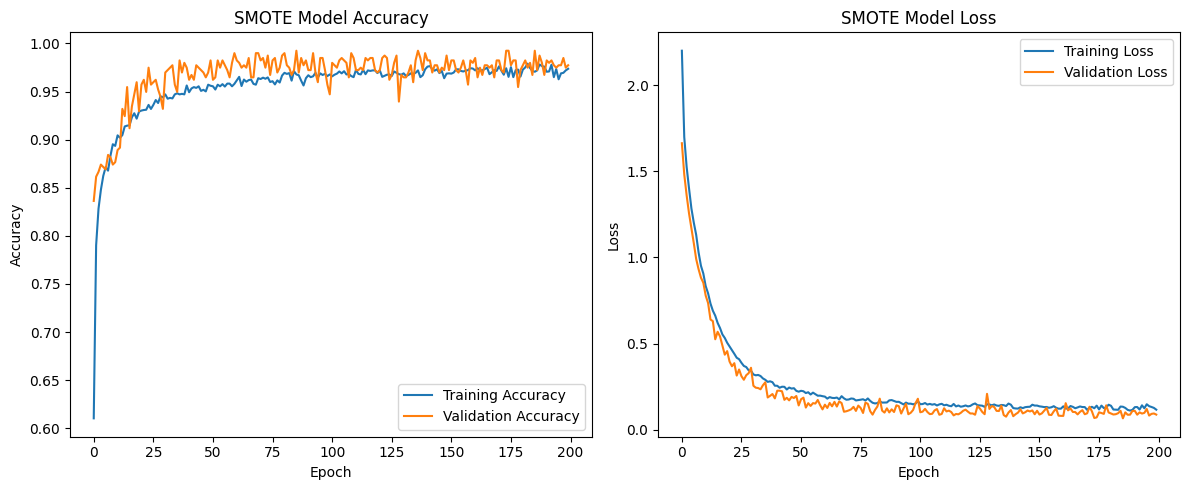

In [28]:
# Plot the training and validation accuracy and loss for SMOTE model
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_smote.history['accuracy'], label='Training Accuracy')
plt.plot(history_smote.history['val_accuracy'], label='Validation Accuracy')
plt.title('SMOTE Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_smote.history['loss'], label='Training Loss')
plt.plot(history_smote.history['val_loss'], label='Validation Loss')
plt.title('SMOTE Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()